In [39]:
import time
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGENodeGenerator
from stellargraph.layer import HinSAGE, Dense
from tensorflow.keras import Model, optimizers, losses, metrics

import time
from sklearn.manifold import TSNE

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

import run

v_sets, e_sets, core_targets, ext_targets = run.main()

Running the scripts sequentially 

LOADING DATA: 59.96 s
SUBSAMPLING: 0.05 s
PREPROCESSING: Complete in 0.05 s


In [3]:
batch_size = 200
epochs = 20
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [4]:
# Initialize SG graph
G = sg.StellarDiGraph(v_sets, e_sets)

In [5]:
nodes_with_labels = v_sets.copy()

In [6]:
ext_targets.size

2693

In [8]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 19071, Edges: 10000

 Node types:
  Account: [11071]
    Features: float32 vector, length 3
    Edge types: Account-money transfer->Account, Account-money transfer->Derived Entity
  Customer: [3449]
    Features: float32 vector, length 5
    Edge types: Customer-has account->Account, Customer-has address->Address, Customer-is similar->External Entity
  Derived Entity: [2975]
    Features: float32 vector, length 4
    Edge types: Derived Entity-is similar->External Entity, Derived Entity-money transfer->Account
  External Entity: [1138]
    Features: float32 vector, length 4
    Edge types: none
  Address: [438]
    Features: float32 vector, length 2
    Edge types: none

 Edge types:
    Account-money transfer->Account: [3278]
        Weights: range=[1, 500], mean=184.361, std=224.779
        Features: none
    Customer-has account->Account: [2979]
        Weights: all 1 (default)
        Features: none
    Account-money transfer->Derived Ent

In [11]:
# Split edges into train and test sets

train_ID, test_ID = model_selection.train_test_split(
    ext_targets, train_size=train_size, test_size=test_size, #stratify=ext_targets
)

In [12]:
# Select only nodes of type "Account" for prediction

train_ID = train_ID[train_ID.index.isin(v_sets['Account'].index)]
test_ID = test_ID[test_ID.index.isin(v_sets['Account'].index)]

In [13]:
# Convert targets labels in one-hot encoded features (optional, for categorical targets)

target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_ID)
test_targets = target_encoding.transform(test_ID)

In [14]:
train_ID.shape

(880, 1)

In [15]:
train_targets.shape

(880, 648)

In [16]:
# USING train_ID vs train_targets ??

In [149]:
labels_train = train_ID
labels_test = test_ID

In [17]:
# Choosing a 2 layer model with 8 nodes sampled in the first layer and 4 in the second.
num_samples = [8, 4]
# we can do 8*4 = 32x32 hidden layer size, since len(num_samples) defines 
# the number of hops (layers) in the HinSAGE model

In [18]:
'''
HinSAGENodeGenerator(G, batch_size, num_samples, head_node_type=None, schema=None, seed=None, name=None)

G = graph
batch_size = size of batch to return
num_samples = the number of samples per layer (hop) to take
head_node_type = the node type that will be given to the generator using the flow method. 
                  The model will expect this type.
                  If not given, it defaults to a single node type.
'''

generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

In [20]:
# Flow

train_gen = generator.flow(train_ID.index, train_targets, shuffle=True)
test_gen = generator.flow(test_ID.index, test_targets)

In [21]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

In [22]:
# Dropout
# (must be tuned)

dropout = 0.0

In [31]:
hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'softmax'],
    generator=generator, 
    bias=True, 
    dropout=dropout
)

In [32]:
# Expose input and output sockets of hinsage:

x_inp, x_out = hinsage.in_out_tensors()

In [44]:
# TSNE

# TODO

In [33]:
# predictions

prediction = Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [34]:
# Model

model = Model(
    inputs=x_inp,
    outputs=prediction
)

In [35]:
# Training

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [46]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8, 3)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 8, 4)]       0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 32, 3)]      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 32, 4)]      0                                            
_______________________________________________________________________________________

In [36]:
history = model.fit(
    train_gen, 
    epochs=epochs,
    validation_data=test_gen,
    verbose=1,
    shuffle=False
)

Epoch 1/20
5/5 [==============================] - 1s 158ms/step - loss: 6.4799 - acc: 0.0023 - val_loss: 2.4603 - val_acc: 0.0112
Epoch 2/20
5/5 [==============================] - 0s 84ms/step - loss: 6.4645 - acc: 0.0068 - val_loss: 2.4584 - val_acc: 0.0112
Epoch 3/20
5/5 [==============================] - 0s 84ms/step - loss: 6.4530 - acc: 0.0057 - val_loss: 2.4564 - val_acc: 0.0112
Epoch 4/20
5/5 [==============================] - 0s 83ms/step - loss: 6.4528 - acc: 0.0091 - val_loss: 2.4533 - val_acc: 0.0056
Epoch 5/20
5/5 [==============================] - 1s 104ms/step - loss: 6.4593 - acc: 0.0045 - val_loss: 2.4577 - val_acc: 0.0056
Epoch 6/20
5/5 [==============================] - 0s 82ms/step - loss: 6.4508 - acc: 0.0057 - val_loss: 2.4526 - val_acc: 0.0084
Epoch 7/20
5/5 [==============================] - 0s 80ms/step - loss: 6.4348 - acc: 0.0068 - val_loss: 2.4505 - val_acc: 0.0056
Epoch 8/20
5/5 [==============================] - 0s 82ms/step - loss: 6.4253 - acc: 0.0091 - v

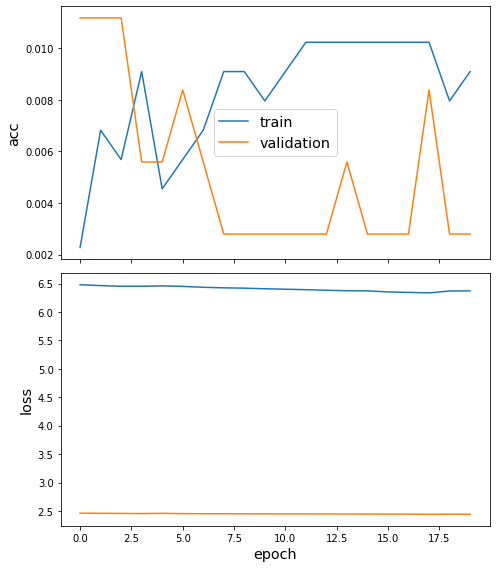

In [37]:
sg.utils.plot_history(history)